# HW9

In [1]:
%run .\DA-cleaning.ipynb
%run .\functions.ipynb

## 1. Decision Tree

In [2]:
from sklearn import tree
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics

### Data 

In [3]:
# Selects variables
df_temp = data[['ID','age', 'antiguedad', 'degree', 'pdhd', 'experience', 
                  'percentage_responsability', 
                  'multicampus', 'seniors',  'total',
                  'total_norm', 'sni_yn', 'score', 'under_yn',
                  'counts_total', 'counts_graduate', 'counts_undergraduate',
                  'counts_highschool', 'mxn_yn', '05num']].copy()

In [4]:
# Separates variables on professor characteristics and class characteristics
prof_var = ['ID','age', 'antiguedad', 'degree', 'pdhd', 'experience', 'total', 'total_norm', 'sni_yn', 'counts_total',
            'counts_graduate', 'counts_undergraduate', 'counts_highschool', 'mxn_yn'];
class_var = [ 'percentage_responsability', 'multicampus', 'seniors', 'score', 'under_yn', 'score_category', '05num']


In [5]:
# Selects the professor variables and eliminates duplicates
df_professor = df_temp[prof_var].sort_values(by=['ID']).drop_duplicates(subset = 'ID', keep='first')

In [6]:
# Create a df of Weighted arithmetic mean of the score by professor
id_list = df_professor.ID.unique()
weighted_score = []
for i in id_list:
    score_professor = df_temp[df_temp.ID == i]['score'].values  
    students_professor = df_temp[df_temp.ID == i]['05num'].values
    weighted_score.append(sum(score_professor * students_professor)/sum(students_professor))

In [7]:
# Adds the weighted score variable to the professor dataset
df_professor['weighted_score'] = weighted_score

In [8]:
# Creates dummy variables
df_professor_dum = pd.get_dummies(df_professor)

In [9]:
# Creates the categorical variable 
cond1 = (df_professor_dum.weighted_score >= df_professor_dum.weighted_score.quantile(0.5)).replace([True,False],[1,0])
#cond3 = (df_professor_dum.weighted_score < df_professor_dum.weighted_score.quantile(0.5)).replace([True,False],[0,''])

df_professor_dum['score_category'] = cond1 # Creates a binary variable
#df_professor_dum = df_professor_dum[df_professor_dum.score_category != ''] # Drops data with no score value

In [10]:
# Drops variables and partitions data into training and testing sets
df_professor_dum = df_professor_dum.drop(columns=['age','antiguedad','experience','ID','weighted_score']) 

In [11]:
X = df_professor_dum.drop(columns=['score_category']);
y = df_professor_dum.loc[:, df_professor_dum.columns == 'score_category']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### Tree Model

In [12]:
# Trains the tree
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(X_train, y_train)

In [13]:
#Testing state
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.515311510031679


### Confusion Matrix

In [14]:
#https://stackoverflow.com/questions/40264763/how-can-i-make-my-confusion-matrix-plot-only-1-decimal-in-python
import itertools
import numpy as np

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Oranges):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_professor_dum.score_category.unique()))
    plt.xticks(tick_marks, rotation=45)
    ax = plt.gca()
    ax.set_xticklabels((ax.get_xticks() +1).astype(str))
    plt.yticks(tick_marks)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[595 343]
 [575 381]]


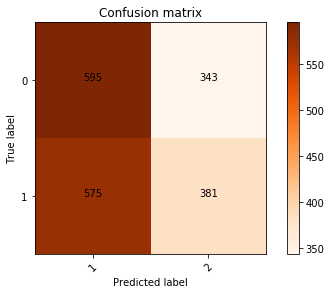

In [15]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
cm = confusion_matrix
np.set_printoptions(precision=1) #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
print('Confusion matrix, without normalization')
print(cm)
fig, ax = plt.subplots()
plot_confusion_matrix(cm)
plt.savefig('Tree_confussion')
plt.show()

### Roc Curve

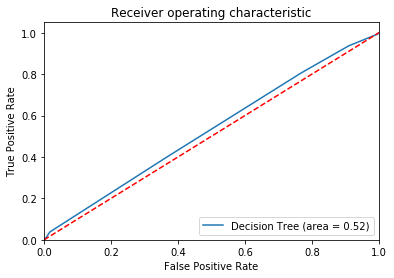

In [16]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

tree_roc_auc = roc_auc_score(y_test, clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Decision Tree (area = %0.2f)' % tree_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Tree_ROC')
plt.show()

In [17]:
#from sklearn.tree import export_graphviz
# Export as dot file

#dot_data = StringIO()

#export_graphviz(clf, out_file=dot_data,  
#                filled=True, rounded=True,
#                special_characters=True)

#graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
#Image(graph.create_png())

In [18]:
#graph.write_png('Tree.png')  

## 2. Random Forest

### Data

In [71]:
# Selects variables
df_temp = data[['ID','age', 'antiguedad', 'degree', 'pdhd', 'experience', 
                  'percentage_responsability', 
                  'multicampus', 'seniors',  'total',
                  'total_norm', 'sni_yn', 'score', 'under_yn',
                  'counts_total', 'counts_graduate', 'counts_undergraduate',
                  'counts_highschool', 'mxn_yn', '05num']].copy()

In [72]:
# Separates variables on professor characteristics and class characteristics
prof_var = ['ID','age', 'antiguedad', 'degree', 'pdhd', 'experience', 'total', 'total_norm', 'sni_yn', 'counts_total',
            'counts_graduate', 'counts_undergraduate', 'counts_highschool', 'mxn_yn'];
class_var = [ 'percentage_responsability', 'multicampus', 'seniors', 'score', 'under_yn', 'score_category', '05num']


In [73]:
# Selects the professor variables and eliminates duplicates
df_professor = df_temp[prof_var].sort_values(by=['ID']).drop_duplicates(subset = 'ID', keep='first')

In [74]:
# Create a df of Weighted arithmetic mean of the score by professor
id_list = df_professor.ID.unique()
weighted_score = []
for i in id_list:
    score_professor = df_temp[df_temp.ID == i]['score'].values  
    students_professor = df_temp[df_temp.ID == i]['05num'].values
    weighted_score.append(sum(score_professor * students_professor)/sum(students_professor))

In [75]:
# Adds the weighted score variable to the professor dataset
df_professor['weighted_score'] = weighted_score

In [76]:
# Creates dummy variables
df_professor_dum = pd.get_dummies(df_professor)

In [77]:
# Creates the categorical variable 
cond1 = (df_professor_dum.weighted_score >= df_professor_dum.weighted_score.quantile(0.5)).replace([True,False],[1,0])
#cond3 = (df_professor_dum.weighted_score < df_professor_dum.weighted_score.quantile(0.5)).replace([True,False],[0,''])

df_professor_dum['score_category'] = cond1 # Creates a binary variable
#df_professor_dum = df_professor_dum[df_professor_dum.score_category != ''] # Drops data with no score value

In [78]:
# Drops variables and partitions data into training and testing sets
df_professor_dum = df_professor_dum.drop(columns=['age','antiguedad','experience','ID','weighted_score']) 

In [79]:
X = df_professor_dum.drop(columns=['score_category']);
y = df_professor_dum.loc[:, df_professor_dum.columns == 'score_category']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### Features

In [80]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [81]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

C:\Users\luiss\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


In [82]:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

No handles with labels found to put in legend.


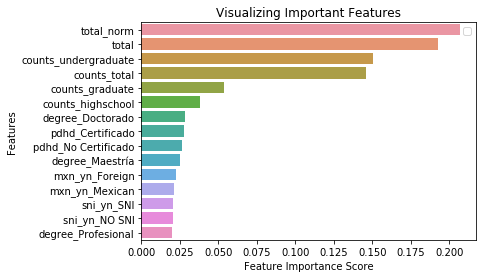

In [83]:
import pandas as pd
feature_imp = pd.Series(clf.feature_importances_,index=X_train.columns).sort_values(ascending=False)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.savefig('features_random')
plt.show()

### Model

In [32]:
# Import train_test_split function
#from sklearn.cross_validation import train_test_split
# Split dataset into features and labels
X = X_train[['total_norm', 'total','counts_undergraduate','counts_total']]  # Removed feature "sepal length"
y = y_train

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.70, random_state=5) #

In [33]:
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

# prediction on test set
y_pred=clf.predict(X_test)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.491273432449903


C:\Users\luiss\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


### Confusion Matrix

Confusion matrix, without normalization
[[1121  442]
 [1132  399]]


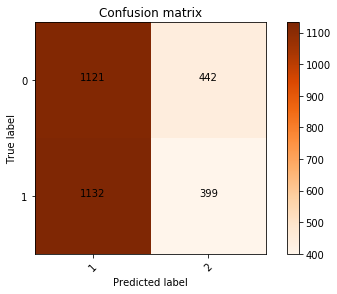

In [34]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
cm = confusion_matrix
np.set_printoptions(precision=1) #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
print('Confusion matrix, without normalization')
print(cm)
fig, ax = plt.subplots()
plot_confusion_matrix(cm)
plt.savefig('Random_confussion')
plt.show()

### ROC Curve

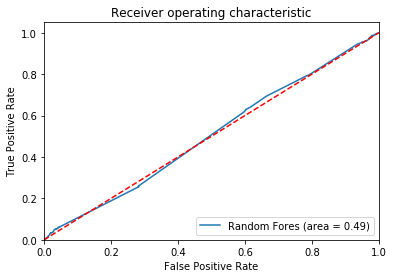

In [35]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

tree_roc_auc = roc_auc_score(y_test, clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Fores (area = %0.2f)' % tree_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Random_ROC')
plt.show()

## 3. Multiple Regression or Logistic Regression

### Data

In [36]:
from sklearn.linear_model import LogisticRegression

In [37]:
# Selects variables
df_temp = data[['ID','age', 'antiguedad', 'degree', 'pdhd', 'experience', 
                  'percentage_responsability', 
                  'multicampus', 'seniors',  'total',
                  'total_norm', 'sni_yn', 'score', 'under_yn',
                  'counts_total', 'counts_graduate', 'counts_undergraduate',
                  'counts_highschool', 'mxn_yn', '05num']].copy()

We have data from **15236** courses  but of **6312** professors, so we will try to group the data by professors. 

We can classify the features into two caterogiries
1. Professor features: 'age', 'antiguedad', 'degree', 'pdhd', 'experience', 'total', 'total_norm', 'sni_yn', 'counts_total',
       'counts_graduate', 'counts_undergraduate', 'counts_highschool',
       'mxn_yn'
2. Class features: 'percentage_responsability', 'multicampus', 'seniors', 'score', 'under_yn'

In [38]:
# Separates variables on professor characteristics and class characteristics
prof_var = ['ID','age', 'antiguedad', 'degree', 'pdhd', 'experience', 'total', 'total_norm', 'sni_yn', 'counts_total',
            'counts_graduate', 'counts_undergraduate', 'counts_highschool', 'mxn_yn'];
class_var = [ 'percentage_responsability', 'multicampus', 'seniors', 'score', 'under_yn', 'score_category', '05num']

In [39]:
# Selects the professor variables and eliminates duplicates
df_professor = df_temp[prof_var].sort_values(by=['ID']).drop_duplicates(subset = 'ID', keep='first')

In [40]:
# Create a df of Weighted arithmetic mean of the score by professor
id_list = df_professor.ID.unique()
weighted_score = []
for i in id_list:
    score_professor = df_temp[df_temp.ID == i]['score'].values  
    students_professor = df_temp[df_temp.ID == i]['05num'].values
    weighted_score.append(sum(score_professor * students_professor)/sum(students_professor))

In [41]:
# Adds the weighted score variable to the professor dataset
df_professor['weighted_score'] = weighted_score

### Creates dummy variables

In [42]:
# Creates dummy variables
df_professor_dum = pd.get_dummies(df_professor)

In [43]:
# Creates the categorical variable 
cond1 = (df_professor_dum.weighted_score >= df_professor_dum.weighted_score.quantile(0.5)).replace([True,False],[1,0])
#cond3 = (df_professor_dum.weighted_score < df_professor_dum.weighted_score.quantile(0.5)).replace([True,False],[0,''])

df_professor_dum['score_category'] = cond1 # Creates a binary variable
df_professor_dum = df_professor_dum[df_professor_dum.score_category != ''] # Drops data with no score value

C:\Users\luiss\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [44]:
# Drops variables and partitions data into training and testing sets
df_professor_dum = df_professor_dum.drop(columns=['age','antiguedad','experience','ID','weighted_score']) 

X = df_professor_dum.drop(columns=['score_category']);
y = df_professor_dum.loc[:, df_professor_dum.columns == 'score_category']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### RFE

In [45]:
# Ranks features, we selected 7 because is half of the features that he have
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
rfe = RFE(estimator = logreg, n_features_to_select=7)
rfe = rfe.fit(X_train, y_train);
print(rfe.support_)
print(rfe.ranking_)

[False False False False  True  True False  True  True  True  True  True
 False False False]
[7 5 3 4 1 1 8 1 1 1 1 1 6 2 9]


C:\Users\luiss\Anaconda3\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\luiss\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\luiss\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\luiss\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\luiss\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will b

In [46]:
# This are the selected variables by RFE
X_train.columns[rfe.support_]

Index(['counts_undergraduate', 'counts_highschool', 'degree_Maestría',
       'degree_Profesional', 'pdhd_Certificado', 'pdhd_No Certificado',
       'sni_yn_NO SNI'],
      dtype='object')

### Implementing the model

In [47]:
# New dataset with less features
X = df_professor_dum.iloc[:,rfe.support_]
y = df_professor_dum['score_category']

In [48]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.689947
         Iterations 4
                           Results: Logit
Model:               Logit             Pseudo R-squared:  0.005     
Dependent Variable:  score_category    AIC:               8725.2720 
Date:                2019-04-21 22:56  BIC:               8772.5246 
No. Observations:    6313              Log-Likelihood:    -4355.6   
Df Model:            6                 LL-Null:           -4375.6   
Df Residuals:        6306              LLR p-value:       4.5061e-07
Converged:           1.0000            Scale:             1.0000    
No. Iterations:      4.0000                                         
--------------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------
counts_undergraduate -0.0669   0.0178 -3.7574 0.0002 -0.1018 -0.0320
counts_highschool     0.3407

In [49]:
# We do the same but dropping features with p>0.05
X = X[['counts_undergraduate','degree_Profesional','pdhd_Certificado']];
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.691177
         Iterations 4
                           Results: Logit
Model:               Logit             Pseudo R-squared:  0.003     
Dependent Variable:  score_category    AIC:               8732.8039 
Date:                2019-04-21 22:56  BIC:               8753.0550 
No. Observations:    6313              Log-Likelihood:    -4363.4   
Df Model:            2                 LL-Null:           -4375.6   
Df Residuals:        6310              LLR p-value:       4.8041e-06
Converged:           1.0000            Scale:             1.0000    
No. Iterations:      4.0000                                         
--------------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------
counts_undergraduate -0.0593   0.0130 -4.5557 0.0000 -0.0849 -0.0338
degree_Profesional    0.2124

### Logistic Regression Model Fitting

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)


C:\Users\luiss\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [51]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.52


### Confusion Matrix

In [52]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[627 311]
 [607 349]]


Confusion matrix, without normalization
[[627 311]
 [607 349]]


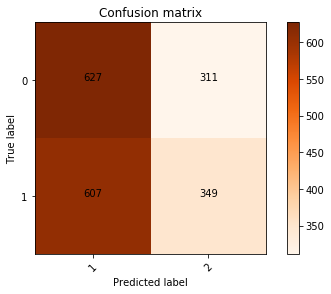

In [53]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
cm = confusion_matrix
np.set_printoptions(precision=1) #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
print('Confusion matrix, without normalization')
print(cm)
fig, ax = plt.subplots()
plot_confusion_matrix(cm)
plt.savefig('Log_confussion')
plt.show()

### ROC Curve

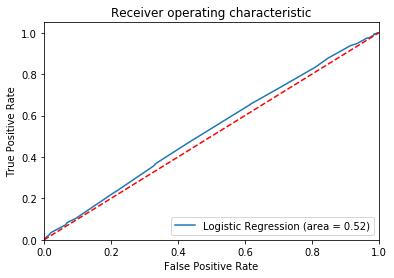

In [54]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## 4. K-Nearest Neighbor

### Data

In [84]:
# Selects variables
df_temp = data[['ID','age', 'antiguedad', 'degree', 'pdhd', 'experience', 
                  'percentage_responsability', 
                  'multicampus', 'seniors',  'total',
                  'total_norm', 'sni_yn', 'score', 'under_yn',
                  'counts_total', 'counts_graduate', 'counts_undergraduate',
                  'counts_highschool', 'mxn_yn', '05num']].copy()

In [85]:
# Separates variables on professor characteristics and class characteristics
prof_var = ['ID','age', 'antiguedad', 'degree', 'pdhd', 'experience', 'total', 'total_norm', 'sni_yn', 'counts_total',
            'counts_graduate', 'counts_undergraduate', 'counts_highschool', 'mxn_yn'];
class_var = [ 'percentage_responsability', 'multicampus', 'seniors', 'score', 'under_yn', 'score_category', '05num']


In [86]:
# Selects the professor variables and eliminates duplicates
df_professor = df_temp[prof_var].sort_values(by=['ID']).drop_duplicates(subset = 'ID', keep='first')

In [87]:
# Create a df of Weighted arithmetic mean of the score by professor
id_list = df_professor.ID.unique()
weighted_score = []
for i in id_list:
    score_professor = df_temp[df_temp.ID == i]['score'].values  
    students_professor = df_temp[df_temp.ID == i]['05num'].values
    weighted_score.append(sum(score_professor * students_professor)/sum(students_professor))

In [88]:
# Adds the weighted score variable to the professor dataset
df_professor['weighted_score'] = weighted_score

In [89]:
# Creates dummy variables
df_professor_dum = pd.get_dummies(df_professor)

In [90]:
# Creates the categorical variable 
cond1 = (df_professor_dum.weighted_score >= df_professor_dum.weighted_score.quantile(0.5)).replace([True,False],[1,0])
#cond3 = (df_professor_dum.weighted_score < df_professor_dum.weighted_score.quantile(0.5)).replace([True,False],[0,''])

df_professor_dum['score_category'] = cond1 # Creates a binary variable
#df_professor_dum = df_professor_dum[df_professor_dum.score_category != ''] # Drops data with no score value

In [91]:
# Drops variables and partitions data into training and testing sets
df_professor_dum = df_professor_dum.drop(columns=['age','antiguedad','experience','ID','weighted_score']) 

In [92]:
X = df_professor_dum.drop(columns=['score_category']);
y = df_professor_dum.loc[:, df_professor_dum.columns == 'score_category']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### Model

In [93]:
from sklearn.neighbors import KNeighborsClassifier

In [94]:
from sklearn import metrics

In [95]:
k_range = range(1,26)
scores = {}
scores_list = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    y_pred=knn.predict(X_test)
    scores[k]=metrics.accuracy_score(y_test,y_pred)
    scores_list.append(metrics.accuracy_score(y_test,y_pred))

C:\Users\luiss\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
C:\Users\luiss\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
C:\Users\luiss\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
C:\Users\luiss\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
C:\Users\luiss\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A

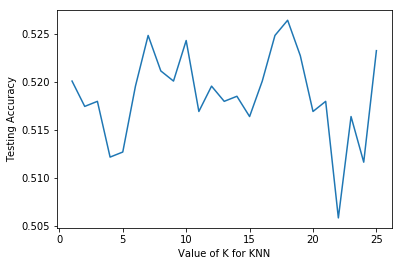

In [96]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(k_range,scores_list)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')
plt.savefig('k_plot')
plt.show()

In [97]:
knn = KNeighborsClassifier(n_neighbors=18)
knn.fit(X,y)
y_pred = knn.predict(X_test)
print('Accuracy:',metrics.accuracy_score(y_test,y_pred))

Accuracy: 0.5406546990496304


C:\Users\luiss\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


### Confusion Matrix

Confusion matrix, without normalization
[[595 343]
 [527 429]]


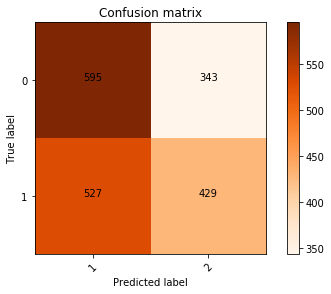

In [98]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
cm = confusion_matrix
np.set_printoptions(precision=1) #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
print('Confusion matrix, without normalization')
print(cm)
fig, ax = plt.subplots()
plot_confusion_matrix(cm)
plt.savefig('knn_confussion')
plt.show()

### ROC Curve

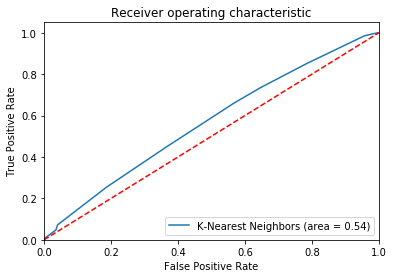

In [99]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
knn_roc_auc = roc_auc_score(y_test, knn.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, knn.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='K-Nearest Neighbors (area = %0.2f)' % knn_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('knn_ROC')
plt.show()

In [101]:
for i in data.columns:
    print(i)

Crn
ID
rectoria
campus
division
department
num_grup
cat_lab
cat_escolar
cat_rh
nationality
gender
age
antiguedad
degree
pdhd
experience
school_national
school_giee
giee
giee_role
SNI
percentage_responsability
level
terminal_group
course_attributes
multicampus
main_professor
seniors
opinions
participation
teach_hours
lecture_hours
lab_hours
credits
05num
05avg
05std
06num
06avg
06std
08num
08avg
08std
books
bseries
proceedings
journal_q1q2
journal_q3q4
total
books_norm
bseries_norm
proceedings_norm
journal_q1q2_norm
journal_q1q2_norm
total_norm
sni_yn
score
under_yn
counts_total
counts_graduate
counts_undergraduate
counts_highschool
mxn_yn
